In [1]:
import glob
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import stats
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.settings.n_jobs = 8
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)

In [2]:
dat = pd.read_excel('../data/Tao.xlsx')

In [3]:
cnt = dat[['J21-1 Read Count', 'J21-2 Read Count','TN21-1 Read Count',
           'TN21-2 Read Count', 'TN21-3 Read Count','TN21-4 Read Count']].copy()
cnt.set_index(dat['Gene Symbol'], inplace=True)

In [5]:
adata = sc.AnnData(cnt.T)
adata.X = csr_matrix(adata.X)
adata.layers['counts'] = adata.X.copy()
adata.obs['ids'] = adata.obs_names.str.split(' ').str[0]
adata.obs.ids = adata.obs.ids.astype('category')
adata.obs['Conditions'] = adata.obs_names.map(lambda x: 'Sham' if 'J' in x else 'TN')
adata.layers['int_counts'] = csr_matrix(cnt.T.round(0).values)

In [6]:
sc.pp.normalize_total(adata, target_sum=1e6, layer='counts')
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()
adata.raw = adata

normalizing counts per cell
    finished (0:00:00)


In [7]:
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=3)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=3
    finished (0:00:00)


/Users/pax/miniconda3/envs/senescence/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/pax/miniconda3/envs/senescence/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/pax/miniconda3/envs/senescence/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

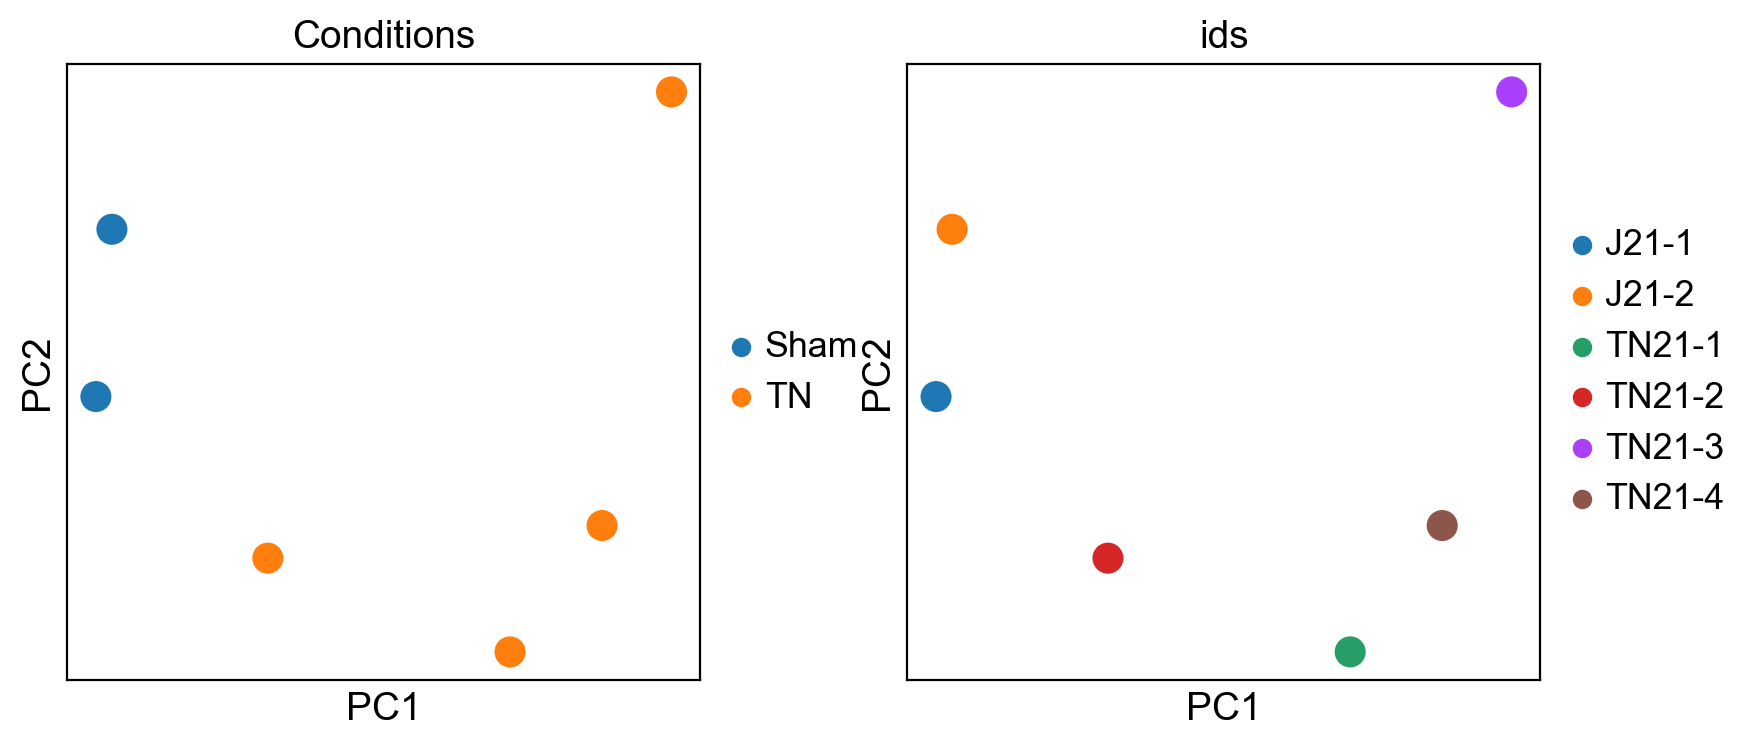

In [8]:
sc.pl.pca(adata, color=['Conditions','ids'], s=500, components=[('1,2')], frameon=True)

In [10]:
senmayo = pd.read_excel('../../SenMayo.xlsx', sheet_name='mouse')['Gene(murine)'].to_list()

In [11]:
sc.tl.score_genes(adata, senmayo, score_name='senmayo', use_raw=False, ctrl_size=len(senmayo))

computing score 'senmayo'
    finished: added
    'senmayo', score of gene set (adata.obs).
    1187 total control genes are used. (0:00:00)


In [17]:
adata.obs['senmayo_z'] = stats.zscore(adata.obs['senmayo'])
adata.obs['senmayo_z'] = adata.obs['senmayo_z'].clip(-1.5, 1.5)

/Users/pax/miniconda3/envs/senescence/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/pax/miniconda3/envs/senescence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pax/miniconda3/envs/senescence/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


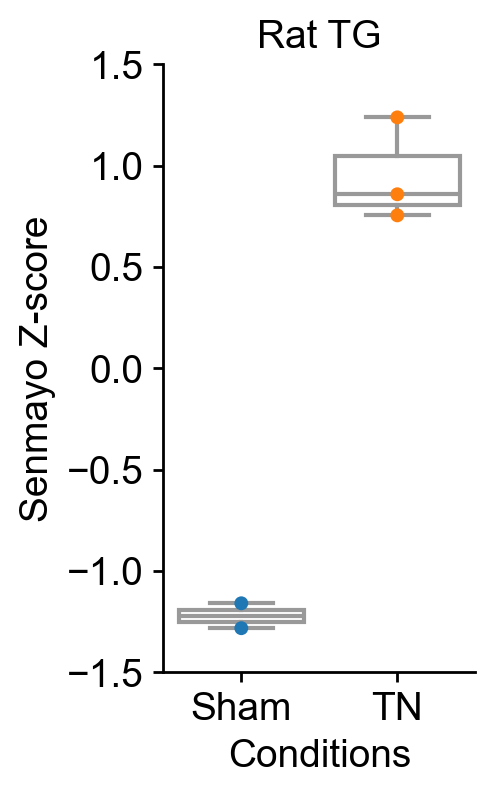

In [37]:
fig, ax = plt.subplots(figsize=(2, 4))
sns.boxplot(x='Conditions', y='senmayo_z', data=adata.obs[adata.obs.ids != 'TN21-2'], ax=ax, color='1')
sns.swarmplot(x='Conditions', y='senmayo_z', data=adata.obs[adata.obs.ids != 'TN21-2'], ax=ax, size=5, hue='Conditions')
ax.legend_.remove()
ax.grid(False)
ax.set_ylim(-1.5, 1.5)
ax.set_ylabel('Senmayo Z-score')
ax.tick_params(width=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
ax.set_title('Rat TG')
fig.savefig('/Users/pax/Library/CloudStorage/OneDrive-KarolinskaInstitutet/BHDrug_plots/HTG_swarm_anno.pdf', bbox_inches='tight')